In [1]:
import networkx as nx
import numpy as np
import pickle as p
from os import path
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib import pyplot as plt
%matplotlib inline
import torch
from node_embeddings.biaised_random_walk import *
from node_embeddings.random_walk import generate_windows, gen_batch_random_walk, get_windows_dotproduct,gen_negative_samples, gen_batch_negative_samples 
from node_embeddings.model import generate_batches, node2vec

data_loc = 'C:/Users/alex_/Fac/M2/M2/S2/Discrete_Graphs/Projet/Data/BlogCatalog3/BlogCatalog-dataset/data/'

## Load Data

In [2]:
def load_data():
    iid = {}
    idx = 0
    edgelist = []

    # Read edges pairs
    with open(data_loc+'edges.csv', 'r') as f:
        for line in f.readlines():
            i, j = line.strip().split(',')  # csv
            if i not in iid:
                iid[i] = idx; idx += 1
            if j not in iid:
                iid[j] = idx; idx += 1
            edgelist.append((iid[i], iid[j]))

    # Create an nx undirected network
    bc = nx.Graph(edgelist)

    print("Number of nodes: ", len(bc))
    print("Number of edges: ", bc.size())

    # Read labels
    labels = np.zeros((len(bc)), dtype=int)
    # Read (node_id, label) file
    with open(data_loc+'group-edges.csv', 'r') as f:
        for line in f.readlines():
            node, group = line.strip().split(',') 
            labels[iid[node]] = int(group)-1  

    bc_dataset = {'graph': bc, 'labels': labels}
    return bc_dataset

bc_dataset = load_data()

Number of nodes:  10312
Number of edges:  333983


In [3]:
embedding, loss_history = node2vec(graph=bc_dataset['graph'],
                                   walks_per_vertex=5,
                                   walk_length=40,
                                   window_size=10,
                                   embedding_size=128,
                                   num_neg=5,
                                   lr=1e-2,
                                   epochs=1,
                                   batch_size=50)

  8%|▊         | 17/206 [00:40<07:35,  2.41s/it]


KeyboardInterrupt: 

(208,)


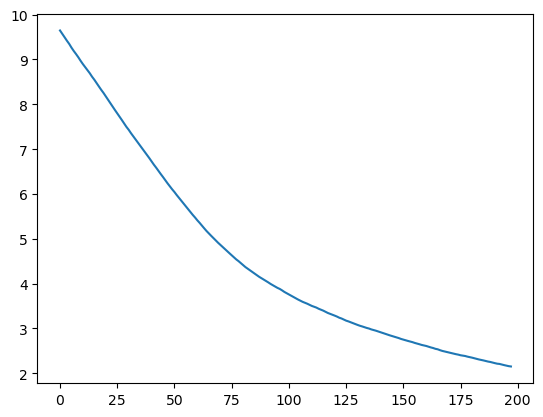

In [ ]:
cumsum_vec = np.cumsum(np.insert(loss_history['total'], 0, 0)) 
print(cumsum_vec.shape)
window_width = 10
ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
plt.plot(ma_vec)
plt.show()

In [ ]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

X = embedding.detach().numpy()
y = bc_dataset['labels']

clf = LogisticRegression(random_state=0).fit(X, y)
y_hat = clf.predict(X)
f1_score(y, y_hat, average='micro')

c:\Users\alex_\anaconda3\envs\pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.14167959658650117